# Arbres de décisions

Dans ce tutoriel, nous allons explorer les arbres de décisions. Les arbres de décisions sont des prédicteurs super intéressants, entre autres puisqu'ils sont interprétables. Ils sont de plus à la base de méthodes bien connues telles que les forêts de décisions et les méthodes de boosting (tel que XGBoost).


Nous allons commencer par explorer ce qu'est un arbre de décision, puis on va s'intéresser à leur fonctionnement.

**Petit disclaimer** J'ai masqué beaucoup de code dans Colab puisqu'il est uniquement nécessaire pour faire des beaux graphiques. Vous pouvez regarder le code, mais ce n'est pas le but du tutoriel.

L'importation des librairies est relativement lent, donc exécutez tout de suite cette cellule. J'ai caché les sorties, si jamais vous avez un problème, enlevez `%%capture` puis regardez le message d'erreur.

In [1]:
# @title Importations des librairies
%%capture
!apt install libgraphviz-dev
!pip install pygraphviz

import pygraphviz as pgv
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing, make_moons
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from matplotlib.colors import to_rgb, to_hex
import graphviz
import inspect
import pandas as pd
import matplotlib.pyplot as plt

# Premier exemple : Deux lunes


Pour bien comprendre, commençons par un exemple de jeu de données. Le jeu de données des deux lunes est un exemple jouet bien connu, puisque c'est un jeu de données facile à visualiser et qui ne peut pas être résolu avec un prédicteur linéaire.

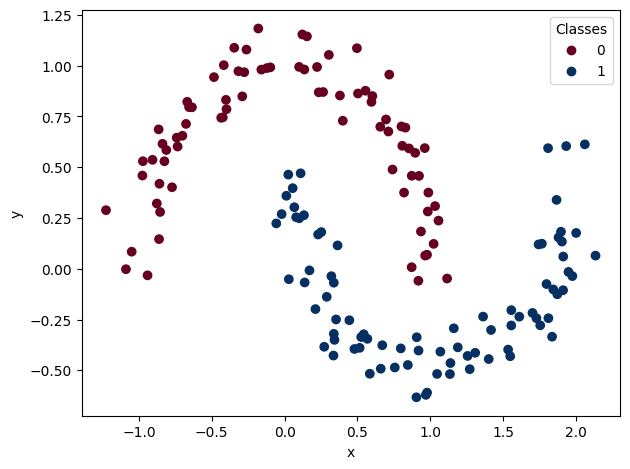

In [2]:
# @title
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.xlabel("x")
plt.ylabel("y")
scatter = plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='RdBu')
handles, labels = scatter.legend_elements()
legend = plt.legend(handles = handles, labels = ["0", "1",], title="Classes")
plt.tight_layout()
plt.show()

Nous allons maintenant entraîner un arbre provenant de scikit-learn. J'ai choisi des paramètres au hasard pour avoir un modèle qui n'est pas trop complexe.

In [3]:
clf = DecisionTreeClassifier(max_depth=2, min_samples_split=4, min_samples_leaf=2, random_state=42, ccp_alpha=0.0)

clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print("Accuracy du modèle :", score)

Accuracy du modèle : 0.925


On affiche la frontière de décision de l'arbre sur les données.

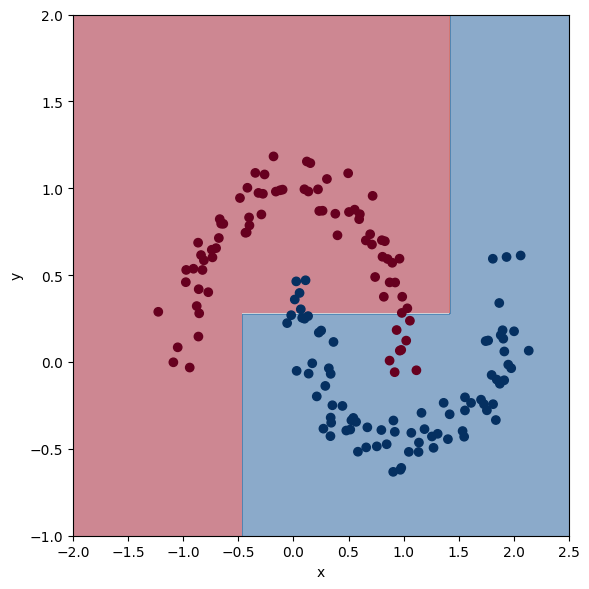

In [4]:
# @title
xx0, xx1 = np.meshgrid(
    np.linspace(-2, 2.5, 500),
    np.linspace(-1, 2, 500),
)

X_grid = np.c_[xx0.ravel(), xx1.ravel()]

plt.figure(figsize=(6,6))
# Plot decision boundary
color = clf.predict(X_grid).reshape(xx0.shape)
plt.contourf(xx0, xx1, color, alpha=0.5, cmap='RdBu')

# Plot data points
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='RdBu')
plt.tight_layout()
plt.show()

C'est bien de voir la frontière de décision, mais est-ce qu'on peut avoir plus d'information?

On peut facilement afficher l'arbre de décision, qui nous donne l'information sur le seuil de décision, sur le critère de sélection (dans notre cas l'impurité de Gini), sur le nombre de données et sur leurs classes.

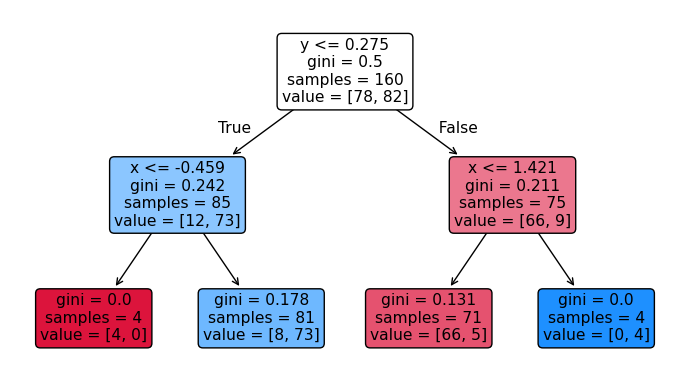

In [5]:
# @title
plt.figure(figsize=(7,4))
colors = ['crimson', 'dodgerblue']
artists = tree.plot_tree(clf, feature_names=["x", "y"],
                         filled=True, rounded=True)
i = 0
j = 0
while i < len(artists):
  artist = artists[i]

  if artist.get_text() != 'True  ' and artist.get_text() != "  False":
    impurity = clf.tree_.impurity[j]
    value = clf.tree_.value[j]
    r, g, b = to_rgb(colors[np.argmax(value)])
    f = impurity * 2
    artist.get_bbox_patch().set_facecolor((f + (1-f)*r, f + (1-f)*g, f + (1-f)*b))
    artist.get_bbox_patch().set_edgecolor('black')
    i+=1
    j+=1
  else:
    i += 1

plt.tight_layout()
plt.show()

Le premier noeud est généralement appelée la racine (*root*) et les noeuds les plus bas sont appelés les feuilles (*leaves*). Les feuilles prédisent la classe majoritaire des données qui s'y trouvent.

On peut savoir comment classifier une donnée en suivant les règles de décisions. En partant de la racine, pour une donnée quelconque, on vérifie si la donnée vérifie l'inégalité. Si c'est le cas, on suit la flèche étiquetée "True". Sinon, on suit la flèche étiquetée "False". On continue ce processus jusqu'à arriver à une feuille.

# Deuxième exemple : Régression sur California Housing

On peut faire un deuxième exemple avec de la régression. Pour ce faire, on peut utiliser un jeu de données de régression proposé par Scikit-Learn, soit California Housing.

Chaque donnée est composée de 8 caractéristiques continues. Dans la cellule suivante, on a la description du jeu de données.

In [6]:
housing = fetch_california_housing()

print(housing['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

Maintenant que l'on comprend un peu mieux notre jeu de données, on peut afficher quelques lignes de données pour avoir une idée du contenu de notre jeu de données.

In [7]:
X = housing.data
y = housing.target

pd.DataFrame(np.concatenate((X[::100,:][:10,:],y[::100][:10].reshape(-1,1)), axis=1), columns=housing.feature_names + housing.target_names)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,2.4912,29.0,3.724800,1.131200,2304.0,1.843200,37.81,-122.25,2.578
2,3.0257,52.0,4.046948,1.009390,994.0,4.666667,37.78,-122.23,0.808
3,1.9479,50.0,4.825203,1.060976,907.0,3.686992,37.76,-122.18,0.895
4,4.2614,52.0,5.520958,0.994012,769.0,2.302395,37.88,-122.28,2.613
5,1.5817,52.0,5.438017,1.173554,875.0,2.410468,37.85,-122.27,1.536
6,3.0000,32.0,4.899135,1.060519,1487.0,2.142651,37.70,-122.07,2.232
7,6.5000,20.0,6.451613,0.806452,83.0,2.677419,37.69,-122.03,3.400
8,2.4808,27.0,4.017316,1.043290,2028.0,2.926407,37.63,-122.07,1.576
9,4.7500,35.0,5.513317,1.016949,1353.0,3.276029,37.53,-121.97,1.970


Finalement, entraînons un arbre de régression sur ce jeu de données. On affiche le R^2 et le RMSE (Root mean squared error). Plus le R^2 est proche de 1, plus le modèle a bien appris. Plus le RMSE est proche de 0, plus le modèle a bien appris.

Contrairement aux arbres de classification, on ne peut pas prédire la classe majoritaire, puisqu'il n'y a pas de classes. On va donc prédire la valeur moyenne de l'étiquette des données qui se trouvent dans un noeud.

Voici les hyperparamètres importants :



1.   **max_depth** : La profondeur maximale de l'arbre
2.   **min_samples_split** : Le nombre minimal de données dans un noeud pour faire un split
3.   **min_samples_leaf** : Le nombre minimal de données minimal pour qu'un noeud soit considéré une feuille
4.   **min_impurity_decrease**: La diminution minimale de l'impurité (entropie de gini ou l'erreur au carré)

Jouez un peu avec les sliders, chaque slider représente un hyperparamètre important pour l'arbre de décision.

R^2 du modèle : 0.27951121634638143
RMSE du modèle :  0.9716660798965697


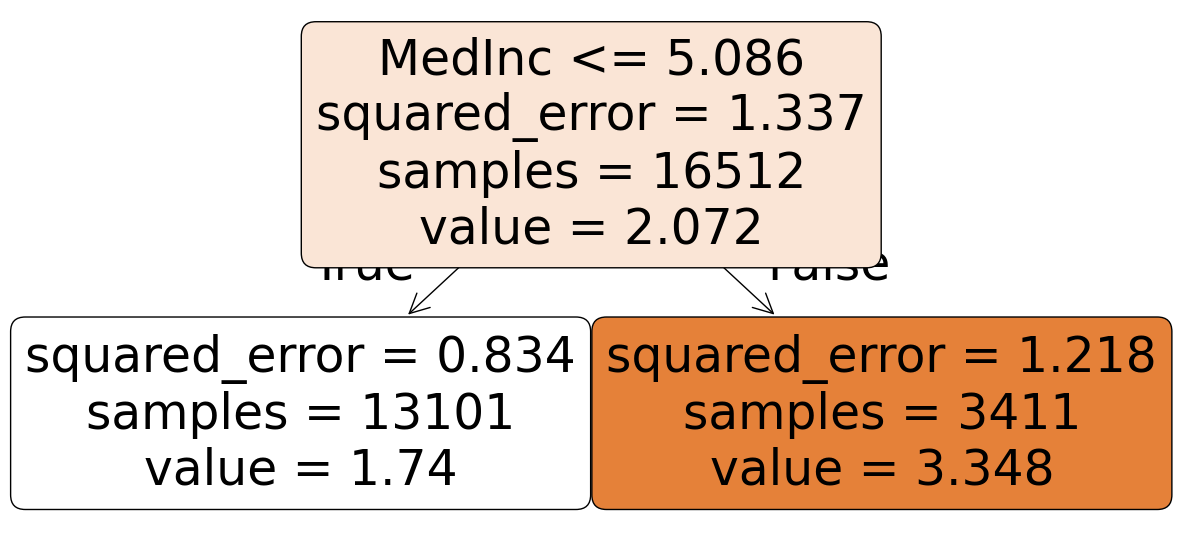

In [16]:
# @title  { run: "auto" }
max_depth = 1 # @param {"type":"slider","min":1,"max":7,"step":1}
min_samples_split = 2 # @param {"type":"slider","min":2,"max":10,"step":1}
min_samples_leaf = 1 # @param {"type":"slider","min":1,"max":10,"step":1}
min_impurity_decrease = 0 # @param {"type":"slider","min":0.0,"max":1.0,"step":0.01}

clf = DecisionTreeRegressor(max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            min_impurity_decrease=min_impurity_decrease,
                            random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
error = np.sqrt(((clf.predict(X_test) - y_test)**2).mean())
print("R^2 du modèle :", score)
print("RMSE du modèle : ", error)

if max_depth < 4:
  plt.figure(figsize=(15,7))
else:
  plt.figure(figsize=(25,15))
tree.plot_tree(clf, feature_names=housing.feature_names,
                         filled=True, rounded=True)
plt.show()

# Comment ça marche?

Pour bien comprendre comment ça marche, pourquoi ne pas regarder du code?

C'est une classe custom que j'ai implémenté il y a un moment car j'avais des besoins spécifiques. On peut utiliser cette classe pour essayer de comprendre comment cela fonctionne. J'ai implémenté les hyperparamètres les plus importants.

## **Explications**
Pour entraîner un arbre de décision, il est nécessaire de savoir quand "splitter" un noeud. Pour ce faire, on a besoin de connaître les critères d'impurités pour les arbres de classification et de classification.

### **Critère de classification**

Pour un noeud quelconque, dénotons $S = \{(\mathbf{x}_i, y_i)\}_{i=1}^{n}$ les données qui se trouvent dans le noeud. On dénote de plus $S_0$ les données avec une étiquette $y=0$ et $S_1$ les données avec $y=1$.

Pour la classification binaire, on a le critère de Gini :
$$H(S) = \sum_{k=1}^2 \frac{|S_k|}{|S|}\bigg(1-\frac{|S_k|}{|S|}\bigg) = 2\frac{|S_0|}{|S|}\frac{|S_1|}{|S|}.$$

Si $|S_0| = 0$ ou $|S_1| = 0$, alors notre noeud est complètement pur et $H(S) = 0$.

Si $|S_0| = |S_1|= \tfrac{1}{2}|S|$, alors notre noeud est complètement impur et $H(S) = \tfrac{1}{2}$.

### **Critère de régression**

Pour un noeud quelconque, dénotons $S = \{(\mathbf{x}_i, y_i)\}_{i=1}^{n}$ les données qui se trouvent dans le noeud.

Le noeud va prédire la moyenne $\bar{y}$ de l'étiquette de ces données, soit

$$\bar{y} = \frac{1}{n} \sum_{y \in S} y.$$

Donc, notre impurité est l'erreur quadratique moyenne, soit:
$$H(S) = \frac{1}{n} \sum_{y \in S} (y-\bar{y})^2.$$

### **Split**

Pour faire la séparation dans un noeud, on va tester tous les splits possibles sur tous les attributs (*features*) des données se trouvant dans le noeud. On peut sauver du calcul en utilisant les paramètres $\texttt{splitter}$ et $\texttt{max_features}$ de la classe des arbres de Scikit-Learn, mais on n'en parlera pas ici.

**Étape 1 : Vérifier que le noeud est valide**

Avant de faire le split d'un noeud, on doit vérifier deux choses:
1.    Est-ce que le nombre de données dans le noeud est plus petit que min_samples_split?
2.    Est-ce que la profondeur du noeud est égale à max_depth?

Si la réponse à l'une de ces deux questions est oui, ce noeud va être une feuille et on ne fait pas de split.

**Étape 2 : Trouver le meilleur split**

Ensuite, on va vérifier chaque split possible. Pour trouver les splits possibles sur l'attribut $d$, on va commencer par trier les données en fonction de la valeur de l'attribut $d$.

En classification, après avoir trier les données, les splits possibles sont ceux où l'étiquette passe d'une classe à une autre, par exemple lorsqu'on a $x < 0.5$, l'étiquette est de $0$, et lorsque $x \geq 0.5$, l'étiquette est de $1$. En régression, on considère un split entre chaque données.

Ensuite, on va calculer l'impureté des noeuds $S^{\text{gauche}}$, qui contient les données qui respectent le split choisi, et $S^{\text{droite}}$, qui contient les données qui ne respectent pas le split choisi. On dénote leur impureté $H(S^{\text{gauche}})$ et $H(S^{\text{droite}})$.

La qualité d'un split $Q(s)$ correspond à la somme pondérée de l'impureté de chaque noeud, soit :

$$Q(s) = \frac{|S^{\text{gauche}}|}{|S|}H(S^{\text{gauche}}) + \frac{|S^{\text{droite}}|}{|S|}H(S^{\text{droite}}).$$


Le meilleur split $s^*$ est sélectionné dans les splits $s$ tels que
$$ s^{*} = \arg\min_{s} \big\{Q(s) |\,H(S) \geq  Q(s) + \text{min_impurity_decrease}\big\}.$$

S'il n'existe aucun split qui a diminué l'impureté du noeud d'au moins min_impurity_decrease, on ne fait aucun split et le noeud devient une feuille.

**Étape 3 : Vérifier que les feuilles sont valides**

Finalement, on vérifie que le split n'a pas créé des noeuds qui ne sont pas légaux. Si $|S^{\text{gauche}}| < \text{min_samples_leaf}$ ou $|S^{\text{droite}}| < \text{min_samples_leaf}$, alors le noeud devient une feuille.



### **Faire pousser l'arbre**

On répète ces étapes récursivement jusqu'à ce que tous les noeuds soient splittés ou des feuilles.


### Source :
[User guide de scikit-learn](https://scikit-learn.org/stable/modules/tree.html#tree)

## Code

Cette section contient tout le code pour implémenter une classe d'arbre de décision custom. Certaines décisions peuvent paraître étranges, mais ça vient d'un de mes projets de recherches que je n'ai pas utilisé finalement. Vous pouvez toute de suite faire rouler la cellule suivante, puis prenez le temps de regarder le code de la classe.

In [17]:
# @title Fonctions utilitaires
class Node:
    def __init__(self, height, n_node_samples, parent_text=None):
        self.height = height
        self.n_node_samples = n_node_samples
        self.is_leaf = False

        self.children_left = None
        self.children_right = None

        self.feature = None
        self.threshold = None
        self.value = None
        self.error = None

        self.compression_set = None
        self.parent_text = parent_text
        self.node_text = None

    def set_feature_threshold(self, feature, threshold):
        self.feature = feature
        self.threshold = threshold

    def get_feature_threshold(self):
        return self.feature, self.threshold

    def set_compression_set(self, set):
        self.compression_set = set

    def get_compression_set(self):
        return self.compression_set

    def set_children(self, left_children, right_children):
        self.children_left = left_children
        self.children_right = right_children

    def get_children_left(self):
        return self.children_left

    def get_children_right(self):
        return self.children_right

    def set_is_leaf(self, value=True):
        self.is_leaf = value

    def get_is_leaf(self):
        return self.is_leaf

    def set_node_text(self, text):
        self.node_text = text

    def get_node_text(self):
        return self.node_text

    def set_node(self, value, error):
        self.value = value
        self.error = error

    def get_error(self):
        return self.error

    def get_value(self):
        return self.value

    def set_compression_data(self, X):
        if type(self.compression_set[0]) is str:
            data_list = [data[:data.find(" + ")] for data in self.compression_set]
            data_set = set(data_list)
            if len(data_set) == 1:
                self.compression_data = self.compression_set[np.argmin([len(data[data.find(" + ") + 3:]) for data in self.compression_set])]
            else:
                data_count = [(data, data_list.count(data)) for data in data_set]
                max_data, max_count = "", 0
                for data, count in data_count:
                    if count > max_count:
                        max_count = count
                        max_data = data

                compression_data = None
                for data in self.compression_set:
                    if max_data in data:
                        if compression_data is None:
                            compression_data = data
                        elif len(data) < len(compression_data):
                            compression_data = data
                self.compression_data = compression_data
        else:
            compression_set = X.loc[self.compression_set].values
            mean = np.mean(compression_set, axis=0)
            index = np.argmin(np.linalg.norm(compression_set - mean, axis=1))
            self.compression_data = self.compression_set[index]

    def get_compression_data(self):
        return self.compression_data


def RGB_to_hex(RGB):
  ''' [255,255,255] -> "#FFFFFF" '''
  # Components need to be integers for hex to make sense
  RGB = [int(x) for x in RGB]
  return "#"+"".join(["0{0:x}".format(v) if v < 16 else
            "{0:x}".format(v) for v in RGB])

def color_gradient(factor):
    gradient = (1-factor) * np.array([255,255,255]) + factor* np.array([217, 133, 73])
    return RGB_to_hex(gradient)

In [18]:
class CustomDecisionTree:
    def __init__(self,
                 splitter="squared_error",
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_impurity_decrease=0,
                 draw_tree=False):
        self.splitter = splitter
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease

        self.depth = 0
        self.n_nodes = 0
        self.n_leaves = 0
        self.fitted = False
        self.list_node = []
        self.compression_set = []
        self.G = None
        self.draw_tree = draw_tree

        if self.splitter == "squared_error":
            self.criterion = self.mean_squared_criterion
        elif self.splitter == "gini":
            self.criterion = self.gini
        else:
          raise NotImplementedError("This splitter is not implemented yet.")

    ########### Criterions ###########
    def mean_squared_criterion(self, y):
        mean_y = np.mean(y)
        return mean_squared_error(y, mean_y*np.ones(y.shape))

    def gini(self,y):
        _, counts = np.unique(y, return_counts=True)
        return 1 - ((counts / len(y))**2).sum()

    ########### Grow the tree ###########

    def fit(self, X, y):
      if X.shape[0] != y.shape[0]:
          raise ValueError("Longueur de X devrait être la longueur de y")
      if self.draw_tree:
          self._initialize_graph()
      self.root = Node(0, X.shape[0])
      X = pd.DataFrame(X)
      self.grow(X, y, self.root, 0)
      self.fitted = True
      self.compute_compression_set(X)
      self.is_fitted_for_sklearn_ = True

    def grow(self, X, y, node, level):
        value = np.mean(y)
        error = self.criterion(y)
        if self.splitter == "gini":
          vals, count = np.unique(y, return_counts=True)
          value = vals[np.argmax(count)]
        node.set_node(value, error)

        self.depth = max(self.depth, level)

        attained_max_depth = (level == self.max_depth)
        no_more_sample_to_split = (X.shape[0] < self.min_samples_split)
        if attained_max_depth or no_more_sample_to_split:
            self.create_leaf(node)
            return

        self.n_nodes += 1
        best_val_d = []
        best_criterion = []

        X_values = X.values
        for d in range(X.shape[1]):
            index_sort = np.argsort(X_values[:, d])
            X_d = X_values[index_sort, d]
            y_d = y[index_sort]
            best_error = np.inf
            best_val = (None, None)
            all_thresholds = np.unique(X_d)
            for threshold in all_thresholds:
                y_l = y_d[X_d <= threshold]
                y_r = y_d[X_d > threshold]
                if not (y_l.size and y_r.size):
                    continue
                left_crit = self.criterion(y_l)
                right_crit = self.criterion(y_r)
                error = (y_l.shape[0]/y.shape[0])*left_crit + (y_r.shape[0]/y.shape[0])*right_crit
                if node.get_error() > error + self.min_impurity_decrease:
                    if error < best_error:
                        best_error = error
                        best_val = (d, threshold)
            best_val_d.append(best_val)
            best_criterion.append(best_error)

        best_index = np.argmin(np.array(best_criterion))
        best_params = best_val_d[best_index]

        if best_params[0] is None:
            self.create_leaf(node)
            return

        # left
        left_index = (X.iloc[:, best_params[0]] <= best_params[1])
        X_l = X[left_index]
        y_l = y[left_index]
        #right
        right_index = (X.iloc[:, best_params[0]] > best_params[1])
        X_r = X[right_index]
        y_r = y[right_index]

        if X_l.shape[0] < self.min_samples_leaf or X_r.shape[0] < self.min_samples_leaf:
            self.create_leaf(node)
            return

        node.set_feature_threshold(best_params[0], best_params[1])

        index = X.loc[X[X.columns[node.feature]] == node.threshold].index
        node.set_compression_set(index)
        node.set_compression_data(X)

        if self.draw_tree:
            self.create_node_text(X.columns[node.feature], node)

        left_node = Node(level+1, X_l.shape[0], parent_text=node.node_text)
        right_node = Node(level+1, X_r.shape[0], parent_text=node.node_text)
        node.set_children(left_node, right_node)
        self.list_node.append(node)
        self.grow(X_l, y_l, left_node, level+1)
        self.grow(X_r, y_r, right_node, level+1)

    def create_leaf(self, node):
        node.set_is_leaf(True)
        self.list_node.append(node)
        self.n_leaves += 1
        if self.draw_tree:
            self.create_node_text(None, node)

    ########### Prediction ###########

    def __predict(self, X, index_list, node):
        if node.get_is_leaf():
            return list(np.ones(X.shape[0])*node.get_value()), index_list

        feature, threshold = node.get_feature_threshold()
        #left
        index_l = (X[:, feature] <= threshold)
        X_l = X[index_l, :]
        indexs_l = list(np.array(index_list)[index_l])
        left_node = node.get_children_left()
        pred_l, i_l = self.__predict(X_l, indexs_l, left_node)

        #right
        index_r = (X[:, feature] > threshold)
        X_r = X[index_r, :]
        indexs_r = list(np.array(index_list)[index_r])

        right_node = node.get_children_right()
        pred_r, i_r = self.__predict(X_r, indexs_r, right_node)

        all_index = i_l + i_r
        all_preds = pred_l + pred_r
        return all_preds, all_index

    def predict(self, X):
        if not self.fitted:
            raise ValueError("L'arbre n'a pas été entraîné.")
        X = pd.DataFrame(X)
        all_preds, all_index = self.__predict(X.values, range(X.shape[0]), self.root)
        return np.array(all_preds)[np.argsort(np.array(all_index))]

    def squared_error(self, X, y):
        predict_y = self.predict(X)
        return np.sum((predict_y - y)**2)

    def r2_score(self, X, y):
        mean_y = np.mean(y)
        variation = np.sum((y - mean_y)**2)
        squared_error = self.squared_error(X, y)
        return 1-(squared_error/variation)

    ########### Utility functions ###########

    def get_depth(self):
        return self.depth

    def compute_compression_set(self, X):
        for node in self.list_node:
            if not node.get_is_leaf():
                self.compression_set.append(node.get_compression_set())
        index_one_element = np.array([True if (len(l) == 1) else False for l in self.compression_set])
        all_one_lists = list(np.array(self.compression_set, dtype=object)[index_one_element])
        all_one_elements = [element[0] for element in all_one_lists]
        compression_set = all_one_elements

        all_more_elements = list(np.array(self.compression_set, dtype=object)[np.logical_not(index_one_element)])

        all_elements = np.array([item for sublist in all_more_elements for item in sublist])

        for liste in all_more_elements:
            number_list = []
            in_list = False
            for element in liste:
                number_list.append(len(np.where(all_elements == element)[0]))
                if element in compression_set:
                    in_list = True
                    break
            if in_list:
                continue
            max_element = liste[np.argmax(np.array(number_list))]
            if not (max_element in compression_set):
                compression_set.append(max_element)
        self.compression_set = compression_set
        self.compression_size = len(self.compression_set)

    def create_node_text(self, node_feature, node):
        tree_label = ""
        if not node.get_is_leaf():
            _, threshold = node.get_feature_threshold()
            tree_label += f"{node_feature} \u2264 {threshold:.3f}\n"

        if self.splitter == "squared_error":
            tree_label += f"squared error = {node.get_error():.3f}\n"
        elif self.splitter == "gini":
            tree_label += f"gini = {node.get_error():.3f}\n"
        else:
          raise NotImplementedError("This splitter is not implemented yet.")
        tree_label += f"samples = {node.n_node_samples}\n"
        tree_label += f"value = {node.get_value():.3f}\n"
        if not node.get_is_leaf():
            c_data = node.get_compression_data()
            tree_label += f"data = {c_data}"

        if np.any([tree_label == node for node in self.G.nodes()]):
              tree_label += " "
        node.set_node_text(tree_label)
        self.G.add_node(tree_label)

        if node.height == 1:
            self.G.add_edge(node.parent_text, node.node_text, label=f"{(self.n_nodes == 2)}")
        elif node.parent_text is not None:
            self.G.add_edge(node.parent_text, node.node_text)

    def draw(self, filename):
        if self.G is None:
            raise RuntimeError("The graph was not initialized.")

        node_list = [node.value for node in self.list_node]
        max_node_value = np.mean(node_list) + 2*np.std(node_list)
        for node in self.G.nodes():
            index_value = node.find("value = ")
            end_index = node.find("\n", index_value)
            value = float(node[index_value + len("value = "):end_index])
            factor = value / max_node_value
            self.G.add_node(node, fillcolor=color_gradient(min(1, factor)))

        self.G.add_subgraph([node for node in self.G.nodes() if "data" not in node], rank="same")
        self.G.layout("dot")
        self.G.draw(filename)

    def _initialize_graph(self):
        self.G = pgv.AGraph(directed=True,
                            rankdir="LR",
                            ranksep="equally",
                            splines="polyline",
                            )
        self.G.node_attr.update(shape="box",
                                style="filled, rounded",
                                fontname="helvetica")
        self.G.edge_attr.update(fontname="helvetica")

class CustomDecisionTreeClassifier(CustomDecisionTree, ClassifierMixin, BaseEstimator):
    def __init__(self,
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_impurity_decrease=0,
                 draw_tree=False):
      super().__init__(max_depth=max_depth,
                 min_samples_split=min_samples_split,
                 min_samples_leaf=min_samples_leaf,
                 min_impurity_decrease=min_impurity_decrease,
                 draw_tree=draw_tree,
                  splitter="gini")

class CustomDecisionTreeRegressor(CustomDecisionTree, RegressorMixin, BaseEstimator):
    def __init__(self,
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_impurity_decrease=0,
                 draw_tree=False):
      super().__init__(max_depth=max_depth,
                 min_samples_split=min_samples_split,
                 min_samples_leaf=min_samples_leaf,
                 min_impurity_decrease=min_impurity_decrease,
                 draw_tree=draw_tree,
                  splitter="squared_error")

## Tester cette nouvelle classe custom sur les deux lunes

Ce qui est intéressant avec cette classe, c'est que je l'avais construite spécifiquement pour que la frontière de décision passe par certains points. Et donc, il est possible d'afficher par quels points notre arbre passe, en utilisant des étoiles.

Accuracy du modèle :  0.925


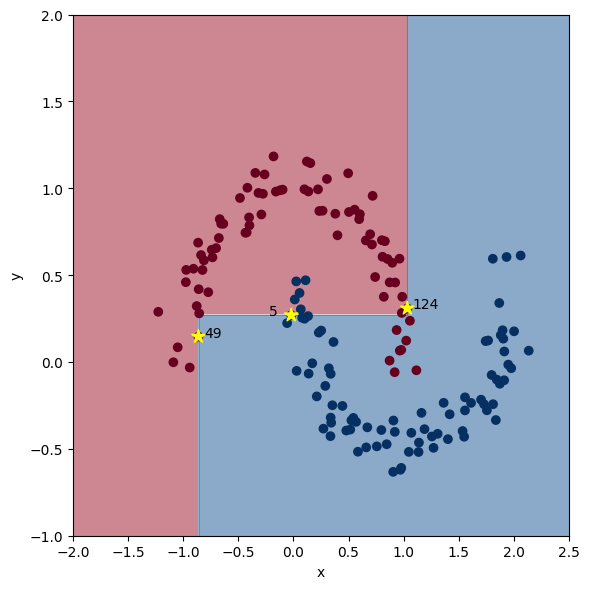

In [19]:
X, y = make_moons(n_samples=200, noise=0.1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = pd.DataFrame(X_train, columns=["x", "y"])
X_test = pd.DataFrame(X_test)

clf = CustomDecisionTreeClassifier(max_depth=2, min_samples_leaf=2, draw_tree=True)
clf.fit(X_train, y_train)
score = clf.score(pd.DataFrame(X_test), y_test)
print("Accuracy du modèle : ", score)

xx0, xx1 = np.meshgrid(
    np.linspace(-2, 2.5, 500),
    np.linspace(-1, 2, 500),
)

X_grid = np.c_[xx0.ravel(), xx1.ravel()]

plt.figure(figsize=(6,6))
# Plot decision boundary
color = clf.predict(X_grid).reshape(xx0.shape)
plt.contourf(xx0, xx1, color, alpha=0.5, cmap='RdBu')

nodes_of_importance = []
data_ = []
for i in range(len(clf.list_node)):
  if clf.list_node[i].compression_set is not None:
      nodes_of_importance.append(clf.list_node[i].compression_set[0])
      data_.append(clf.list_node[i].get_compression_data())

# Plot data points
plt.xlabel("x")
plt.ylabel("y")
plt.text(X_train.values[nodes_of_importance[0],0]-0.2,X_train.values[nodes_of_importance[0],1], s=str(data_[0]))
plt.text(X_train.values[nodes_of_importance[1],0]+0.05,X_train.values[nodes_of_importance[1],1], s=str(data_[1]))
plt.text(X_train.values[nodes_of_importance[2],0]+0.05,X_train.values[nodes_of_importance[2],1], s=str(data_[2]))
plt.scatter(X_train.values[:,0], X_train.values[:,1], c=y_train, cmap='RdBu')
plt.scatter(X_train.values[nodes_of_importance,:][:,0], X_train.values[nodes_of_importance,:][:,1], marker="*", s=100, c=['yellow', 'yellow', 'yellow'])
plt.tight_layout()

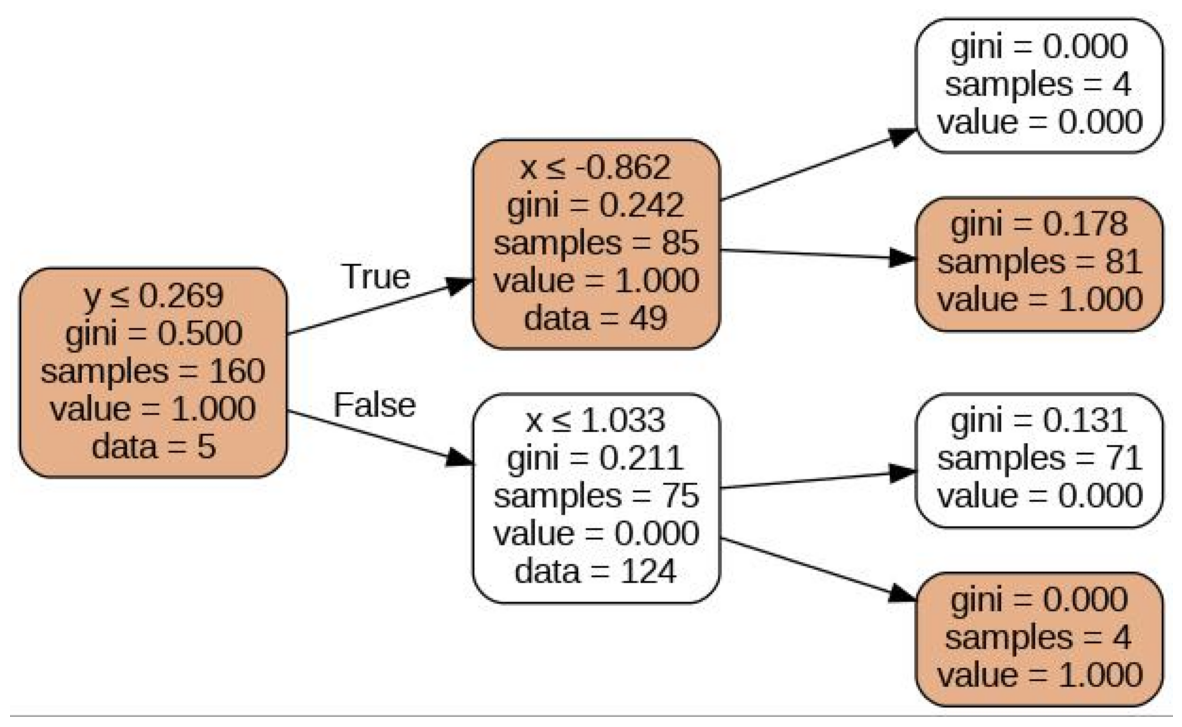

In [20]:
clf.draw("tree.jpg")
plt.figure(figsize=(15,15))
image = plt.imread("tree.jpg")
plt.imshow(image)
plt.axis("off")
plt.show()

## Tester cette nouvelle classe custom sur california housing

J'avais aussi construit cette classe pour qu'elle puisse être utilisée spécifiquement avec Scikit-Learn. Donc en plus de faire un exemple sur California Housing, je l'utilise dans un pipeline de GridSearchCV pour faire de la recherche en grille d'hyperparamètres avec de la validation croisée.

In [21]:
scdt = CustomDecisionTreeRegressor(max_depth=7, draw_tree=True)
parameters = {'min_samples_split': [2, 3, 4, 5, 6],
            'min_samples_leaf': [2, 3, 4, 5, 6]}
scoring = {"r2": 'r2', 'rmse': 'neg_root_mean_squared_error'}
clf = GridSearchCV(scdt, scoring=scoring, param_grid=parameters, refit='r2')
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
score

0.696969696969697

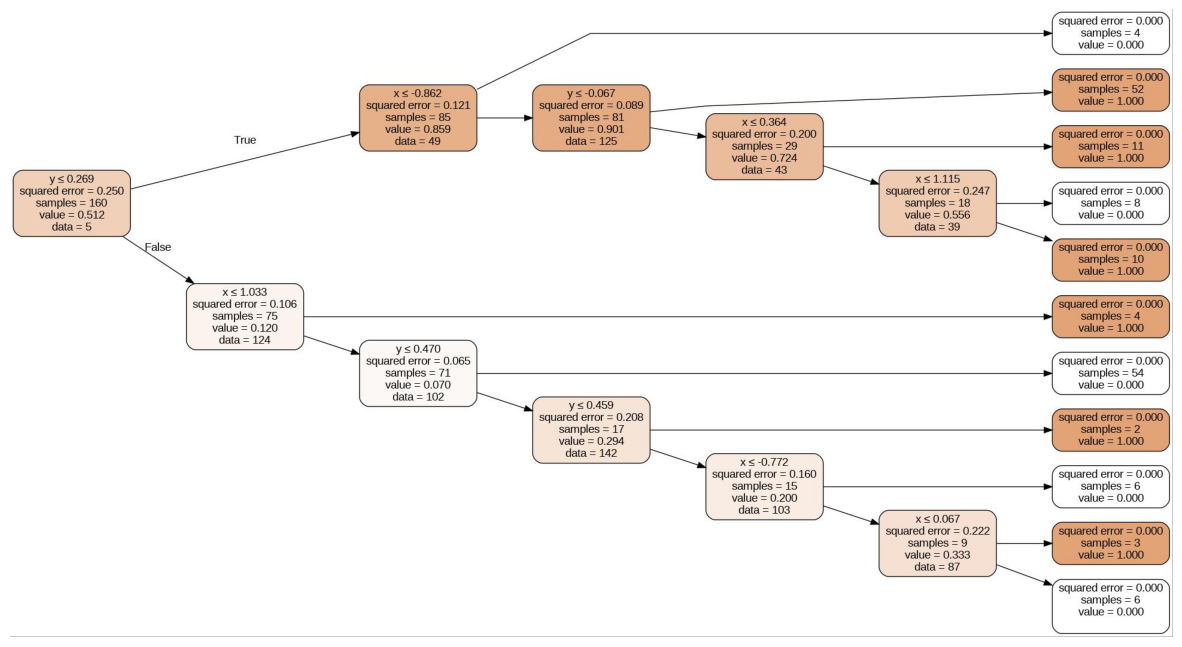

In [22]:
clf.best_estimator_.draw("tree_housing.jpg")
plt.figure(figsize=(15,15))
image = plt.imread("tree_housing.jpg")
plt.imshow(image)
plt.axis("off")
plt.show()